====================================
Tutorial 6 - Play with EIT using NRV
====================================

Here is a tutorial showing the basic usage of ``nrv.eit`` sub-package. 

The tutorial is divided in 2 sections:
 - **The forward problem**: Measurement data are generated with FEM simulation (using [GMSH](https://gmsh.info/doc/texinfo/gmsh.html) and [FEniCSx](https://docs.fenicsproject.org) libraries) methods embedded in `nrv.eit.forward_problem`.
 - **The forward problem**: Image reconstruction is performed on the measurement data (using [pyEIT](https://github.com/eitcom/pyEIT)) methods implemented in `nrv.eit.inverse_problem`.

In [1]:
import sys
sys.path.append("../../NRV")
import nrv
import nrv.eit as eit
import numpy as np
import matplotlib.pyplot as plt
import os


test_id = "6"
res_dir  = f"./{test_id}/"


np.random.seed(4444)


Simulate the Measure (*forward problem*)
========================================

The main objective of this part is to simulate, for a given neural activity, the impedance change measured by multipolar cuff electrodes.

Setting parameters
------------------

First, let's define the nerve geometry for the simulation. As a case study, we can create a two-fascicle nerve as in a previous tutorial (see :doc:`Tutorial 4 <./4_nerve_simulation>`).

:: note..
    Here the generated nerve is only stored in a ``dict``, but it could also be saved in a `.json` file and loaded afterwards.


Output()

NRV INFO: On 30 axons to generate, there are 9 Myelinated and 21 Unmyelinated


Output()

NRV INFO: On 10 axons to generate, there are 3 Myelinated and 7 Unmyelinated


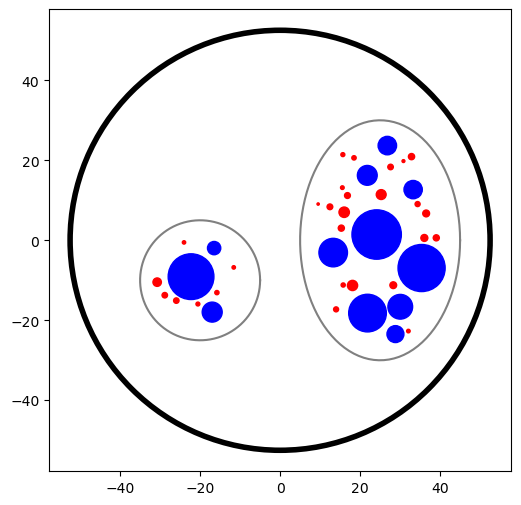

In [2]:

outer_d = 5     # mm
nerve_d = 105  # um
nerve_l = 15010  # um
percent_unmyel = .7
unmyelinated_nseg = 3000
axons_data={
    "diameters":[10.001],
    "types":[1],
    "y":[0],
    "z":[0],
}

nerve_1 = nrv.nerve(length=nerve_l, diameter=nerve_d, Outer_D=outer_d, postproc_label="sample_keys", record_g_mem=True)

# Adding first fascicle
n_ax1=30
fasc1_d = (40, 60)   # um
fasc1_y = 25     # um
fasc1_z = 0     # um
fascicle_1 = nrv.fascicle(diameter=fasc1_d, ID=1, unmyelinated_nseg=unmyelinated_nseg)
fascicle_1.fill(n_ax=n_ax1, percent_unmyel=percent_unmyel, M_stat="Ochoa_M", U_stat="Ochoa_U", fit_to_size=False,delta=.5, delta_trace=3)
nerve_1.add_fascicle(fascicle=fascicle_1, y=fasc1_y, z=fasc1_z)

# Adding second fascicle
n_ax2=10
fasc2_d = 30   # um
fasc2_y = -20     # um
fasc2_z = -10     # um
fascicle_2 = nrv.fascicle(diameter=fasc2_d, ID=2, unmyelinated_nseg=unmyelinated_nseg)
fascicle_2.fill(n_ax=n_ax2, percent_unmyel=percent_unmyel, M_stat="Ochoa_M", U_stat="Ochoa_U", fit_to_size=False,delta=.5, delta_trace=3)
nerve_1.add_fascicle(fascicle=fascicle_2, y=fasc2_y, z=fasc2_z)

nerve_data = nerve_1.save(save=False)

fig, ax = plt.subplots(figsize=(6, 6))
nerve_1.plot(ax)

del nerve_1

Next, let's define the simulation parameters for the EIT forward problem. 

This includes specifying the geometry, electrode configuration, stimulation protocol, and other relevant settings required to set up and run the finite element simulation of impedance measurements.



In [3]:
n_proc_global = 3 


l_elec = 1000 # um
x_rec = 3000 # um
i_drive = 30 # uA
#dt_fem = 1 # ms
t_sim=10 # ms
t_iclamp = 0 # ms
n_fem_step = 10*n_proc_global

dt_fem = [
    (2, .75),
    (7,.4),
    (-1,.75),
        ]

n_elec = 16


sigma_method = "mean"
inj_protocol_type = "simple"
use_gnd_elec = True
parameters = {"x_rec":x_rec,
"dt_fem":dt_fem,
"inj_protocol_type":inj_protocol_type,
"n_proc_global":n_proc_global,
"l_elec":l_elec,
"i_drive":i_drive,
"sigma_method":sigma_method,
"use_gnd_elec":use_gnd_elec,
"n_elec":n_elec,
}

Run the simulation
------------------

EIT simulations can be done in three steps:

 1. **Nerve Simulation**: Simulation of the neural context.
 2. **Mesh Generation**: Creation of the problem geometry and physical domains.
 3. **EIT Simulation**: Simulation of the electric field inside the nerve for a given injection protocol.

.. tip::
    These three steps, especially the latter, can be quite long. It can be interesting to adapt the number of process 

All these steps can be done from a single ``eit.EIT2DProblem``-object.

Let's start by instantiate the problem using the parameter set above.

.. tip::
    you can find a list of tunable attribute in the API documentation (see :class:`nrv.eit.EIT2DProblem`)

In [4]:
eit_instance = eit.EIT2DProblem(nerve_data, res_dname=res_dir, label=test_id, **parameters)

**Nerve Simulation**

As mention, the first step consist at simulated the electrical conductivity change of axons' membrane induced by the activity. This can be done by calling :meth:`nrv.eit.eit_forward.simulate_nerve`-method.

.. tip::
    The arguments can be more simply understood as the combinaison of three arguments of the :class:`nrv.nmod.nerve`-class: :meth:`nrv.nrv.nmod.nerve.insert_I_Clamp`, :meth:`nrv.nmod.nerve.set_axons_parameters` and :meth:`nrv.nmod.nerve.simulate`.

Basically, this method:
1. Adapt the nerve-object to match with the problem parameter.
2. Attach a current clamp to axons in the nerve.
3. Attach analytical recording points at the center of each electrode
4. Run the nerve simulation storing the axons' membrane conductivity values for each temporal step of the FEM simulation.
5. If specified, save the simulation results in a `.json` file (in :attr:`nrv.eit.eit_forward.nerve_res_file`).


.. note::
    A customized on the flight post-processing is used to only store required values of membranes conductivity (see :func:`nrv.eit.utils.sample_nerve_results`).


In [5]:
## Nerve simulation
sim_param = {"t_sim":t_sim}
nrn_res = eit_instance.simulate_nerve(t_start=t_iclamp, sim_param=sim_param, fasc_list=[1])

Output()

NRV INFO: Starting nerve simulation


Output()

NRV INFO: ...Done!


Let's now plot the nerve highlighting the fibres activated during the simulation, as done in :doc:`Tutorial 4 <./4_nerve_simulation>`.

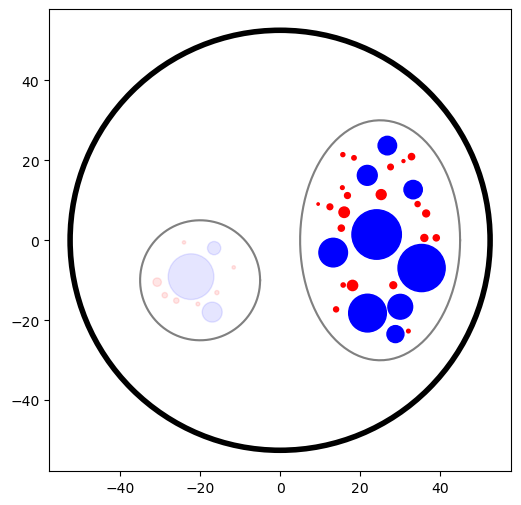

In [6]:
fig, ax = plt.subplots(figsize=(6, 6))
nrn_res.plot_recruited_fibers(ax)

**FEM Problem**

Once the nerve simulation is complete, the goal of the following steps is to compute how changes in axonal membrane conductivity affect impedance measurements from extracellular electrodes. This is achieved by using FEM to calculate the electric field inside the nerve over time, for a given current injection between a pair of electrodes.

Although this process may seem complex, it has been fully integrated into the ``eit_forward`` class and can be performed in three lines:
1. :meth:`nrv.eit.eit_forward._setup_problem`: Sets up the FEM problem using the geometrical and electrical properties stored in the :class:`nrv.nmod.results.nerve_results` output from the nerve simulation.

.. warning::
    This step may be merged with the next one in future versions of NRV.

2. :meth:`nrv.eit.eit_forward.build_mesh`: Builds the mesh corresponding to the nerve geometry, including the multipolar cuff electrodes.
3. :meth:`nrv.eit.eit_forward.simulate_eit`: Runs the FEM simulation over all time, frequency, and drive pattern steps.

.. note::
    Currently, the mesh is always saved in a `.msh` file (see :attr:`nrv.eit.eit_forward.nerve_res_file`) and reloaded at the beginning of each process during the simulation. This behaviour may change in future versions of NRV.


In [7]:
## Impedance simulation
eit_instance._setup_problem()
# Build mesh
eit_instance.build_mesh()

# Simulate nerve
fem_res = eit_instance.simulate_eit()

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 489
NRV INFO: Number of nodes : 5615
NRV INFO: Number of elements : 11680


Output()

The object returned by the EIT simulation is an instance of :class:`nrv.eit.results.eit_forward_results`. The main purposes of this class are to:
- Store the results of the simulations.
- Facilitate access to specific results.
- Provide post-processing and plotting tools to analyze the results.

Similar to other results classes in NRV, this class inherits from :class:`dict`. However, to limit memory usage, only the following keys are stored:

- `"t"`: Time vector of the FEM simulation results.
- `"f"`: Frequency vector of simulation results.
- `"p"`: Drive protocol used in the simulation.
- `"v_eit"`: Voltage measurements magnitude from the EIT simulation.
- `"v_eit_phase"`: Phase of the voltage measurements.
- `"t_rec"`: Time vector of the nerve simulation results (for analytical recording).
- `"v_rec"`: Voltage values recorded by the analytical recorders.

In this tutorial, we primarily use the results to feed the inverse problem and perform image reconstruction. Therefore, the various post-processing tools implemented in this class will not be detailed here.

:: seealso::

    - EIT users' guide.
    - Examples.

Let's plot the impedance shift measured at each electrode over time for one drive pattern to better understand what have been simulated.

[<Axes: title={'center': 'E0'}>,
 <Axes: title={'center': 'E1'}>,
 <Axes: title={'center': 'E2'}>,
 <Axes: title={'center': 'E3'}>,
 <Axes: title={'center': 'E4'}>,
 <Axes: title={'center': 'E5'}>,
 <Axes: title={'center': 'E6'}>,
 <Axes: title={'center': 'E7'}>,
 <Axes: title={'center': 'E8'}>,
 <Axes: title={'center': 'E9'}>,
 <Axes: title={'center': 'E10'}>,
 <Axes: title={'center': 'E11'}>,
 <Axes: title={'center': 'E12'}>,
 <Axes: title={'center': 'E13'}>,
 <Axes: title={'center': 'E14'}>,
 <Axes: title={'center': 'E15'}>,
 <Axes: >]

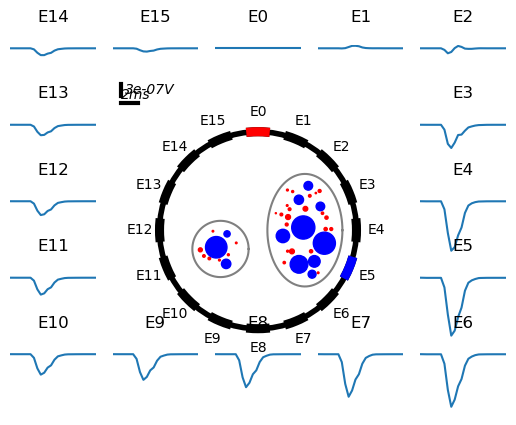

In [8]:
pat = fem_res["p"][0]
dv_pc = fem_res.dv_eit(i_p=0)

fig = plt.figure()
_, axs2 = eit.utils.gen_fig_elec(n_e=fem_res.n_e, fig=fig, )

eit.utils.add_nerve_plot(axs=axs2, data=nerve_data, drive_pair=pat)
eit.utils.plot_all_elec(axs=axs2, t=fem_res.t(), res_list=dv_pc,)
eit.utils.scale_axs(axs=axs2, e_gnd=[0], has_nerve=True)



The previous plot can be extended to all injection patterns. However, for a 16-electrode protocol, the resulting image is not very readable.


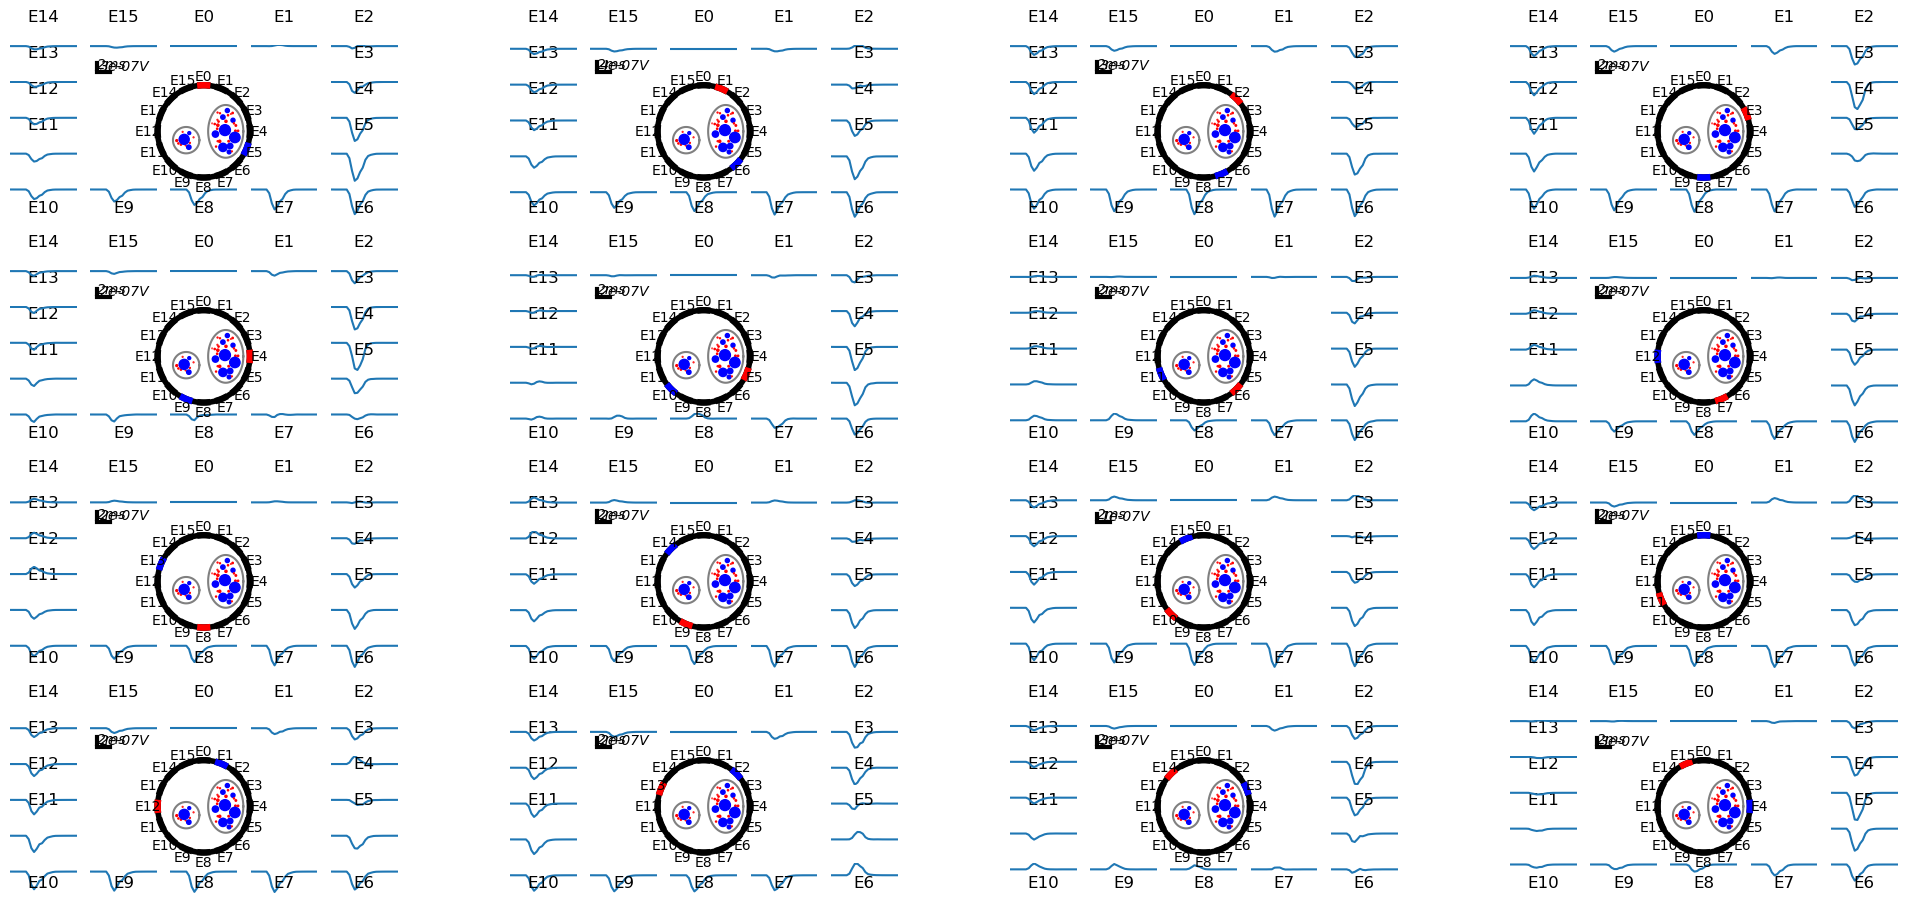

In [9]:
if n_elec in [8, 16]:
    fig = plt.figure(figsize=(20, 9))
    subfigs = fig.subfigures(n_elec//4, 4)
    axs = np.array([])
    for i_p, pat in enumerate(fem_res["p"]):
        dv_pc = fem_res.dv_eit(i_p=i_p)
        _, axs2 = eit.utils.gen_fig_elec(n_e=fem_res.n_e, fig=subfigs[i_p//4, i_p%4], small_fig=True)
        eit.utils.add_nerve_plot(axs=axs2, data=nerve_data, drive_pair=pat)
        eit.utils.plot_all_elec(axs=axs2, t=fem_res.t(), res_list=dv_pc,)
        axs = np.concatenate([axs, axs2[1:-1]])
        eit.utils.scale_axs(axs=axs2, e_gnd=[0], has_nerve=True)

.. tip::
    As mention above, only the voltage measured by the electrode is saved in eit_forward_results. To better understand the computed results, or to debug some eventual issues, it is still possible to save the electric field in the whole nerve. This can be done using the :meth:`nrv.eit.eit_forward.run_and_savefem`-method as bellow. This method save the output of the FEM in a ``.bp`` folder which can be open with `Paraview <https://www.paraview.org>`_

    .. code-block::
        eit_instance.run_and_savefem(sfile=res_dir+"test")

## Reconstruct the image (*inverse problem*)

The reconstruction is adapted from the *Pyeit* `dynamic Jacobian example<https://github.com/eitcom/pyEIT/tree/master/examples>`_.

The reconstruction consists of finding the conductivity distribution in a mesh that best matches the measurements. This adjustment is carried out using optimization algorithms and can be processed by *pyEIT* as follows:

1. Results must be formatted to be compatible with *PyEIT* (a 1D array containing the differential measurements in the correct order).
2. The measurement parameters (number of electrodes, type of protocol, ...) must be defined with *PyEIT* tools.
3. The *PyEIT* solver must be set and apply at to reconstruct the map of activity in the nerve at desired time steps.

**Implementation**

In NRV, this all this can be done using the :class:`nrv.eit.pyeit_inverse`-class. As shown bellow, this class can be directly instantiated from an :class:`nrv.eit.results.eit_forward_results`

In [10]:
inv_pb = eit.pyeit_inverse(data=fem_res)

(16, 16)


Text(0.5, 1.0, 'Diferentrial measurements')

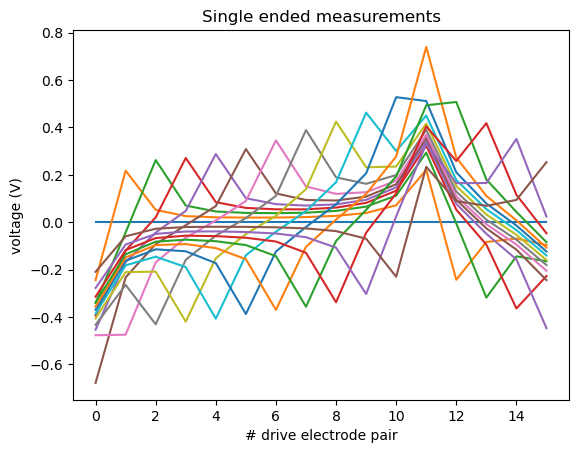

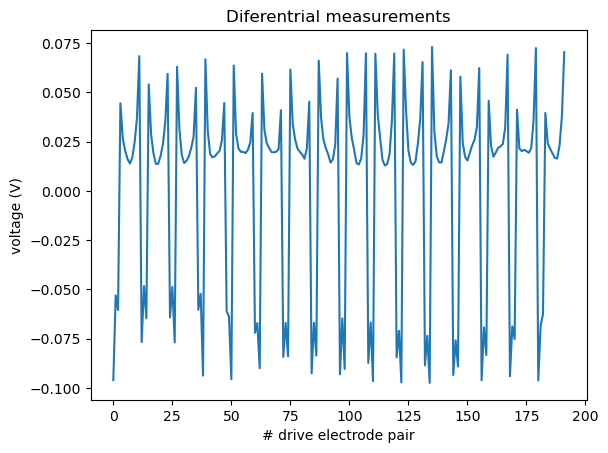

In [11]:
print(fem_res.v_eit(i_t=0,signed=True).shape)
plt.figure()
plt.plot(fem_res.v_eit(i_t=0,signed=True))

plt.xlabel("# drive electrode pair")
plt.ylabel("voltage (V)")
plt.title("Single ended measurements")
plt.figure()
plt.plot(inv_pb.fromat_data())
plt.xlabel("# drive electrode pair")
plt.ylabel("voltage (V)")
plt.title("Diferentrial measurements")

For this first tutorial, only one image will be generated at the peak of activity.

The reconstruction method used is dynamic, thus two sets of measurements are required:

 - When the fibres are at rest `t=0` (``i_t=0``).
 - At the peak of activity `t=t_max`.

To find the index ``i_tmax``, a simple method consists of examining ``res.dv_eit`` for one electrode over time and finding the time point where the absolute value is maximal, as done in the next cell.

t_max=3.6000000000003696ms, (i_tmax=7)


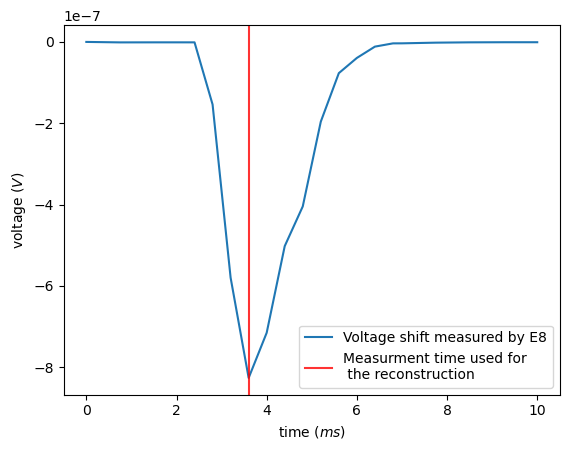

In [12]:
_dv = fem_res.dv_eit(i_e=fem_res.n_e//2, i_p=0,)

i_tmax = np.argmax(np.abs(_dv))

print(f"t_max={fem_res["t"][i_tmax]}ms, (i_tmax={i_tmax})")


fig, ax = plt.subplots()
ax.plot(fem_res.t(), fem_res.dv_eit(i_e=fem_res.n_e//2, i_p=0), label=f"Voltage shift measured by E{int(fem_res.n_e//2)}")
ax.axvline(fem_res["t"][i_tmax], color=("r",.8), label="Measurment time used for\n the reconstruction")
ax.set_xlabel("time ($ms$)")
ax.set_ylabel("voltage ($V$)")
ax.legend()

If required the data formatted for pyEIT solvers can be extracted using `fromat_data` as shown bellow:

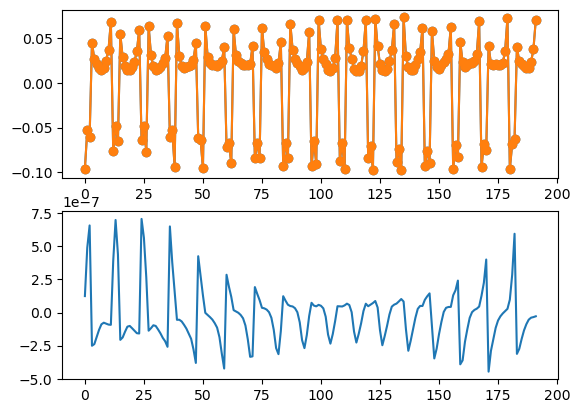

In [13]:
v0 = inv_pb.fromat_data(i_t=0)
v1 = inv_pb.fromat_data(i_t=i_tmax)

fig, axs = plt.subplots(2)
axs[0].plot(v0, "-o")
axs[0].plot(v1, "-o")

axs[1].plot(v1-v0)

Here is where the reconstruction is done. 

To reconstruct the images from the measurements the mesh and scan protocol have to be initialized in *Pyeit*

Then the solver object is defined and used on the two sets of measurements. 

In [14]:
ds = inv_pb.solve(i_t=i_tmax)[0]

print(type(ds), ds.shape, inv_pb.mesh_obj.node.shape, inv_pb.mesh_obj.element.shape)

<class 'numpy.ndarray'> (2821,) (1476, 3) (2821, 3)


Finally, the reconstruction can be plotted with `matplotlib` as bellow:

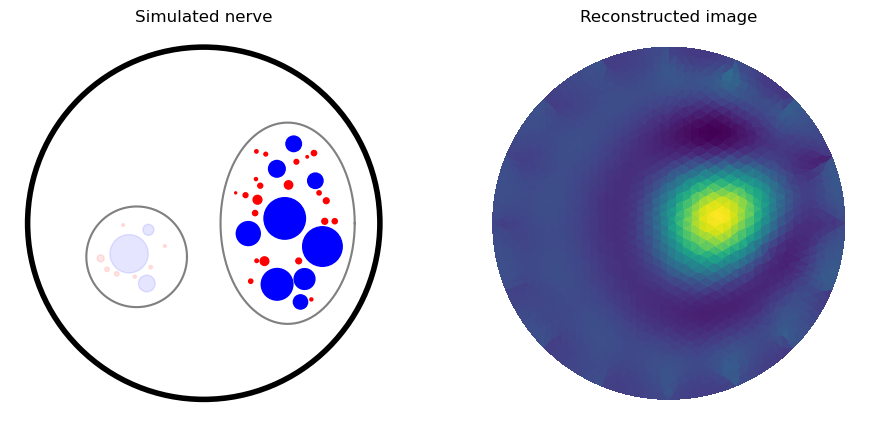

In [15]:
# draw
fig, axs2 = plt.subplots(1, 2, figsize=(11, 9))

nrn_res.plot_recruited_fibers(axs2[0])
axs2[0].set_title("Simulated nerve")
axs2[0].set_axis_off()

inv_pb.plot(ax=axs2[1], i_t=i_tmax)
axs2[1].set_title("Reconstructed image")
axs2[1].set_aspect("equal", adjustable="box")

An additional filter can be applied when plotting the reconstructed image.

As an example lets use a simple threshold filter (see :func:`nrv.eit.utils.thr_window`) to highlight only the activated region.

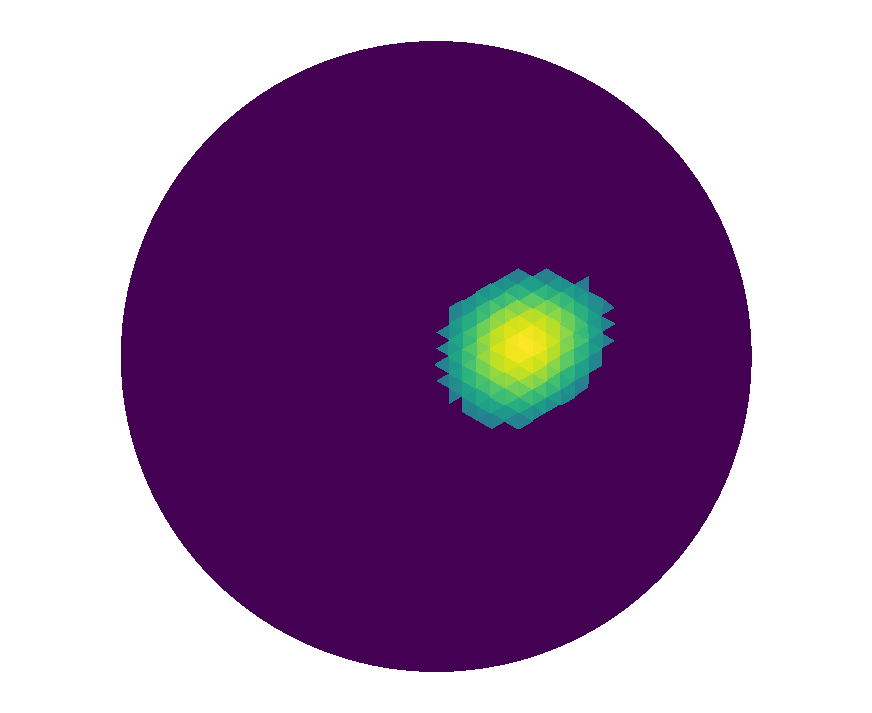

In [16]:
fig, ax2 = plt.subplots(figsize=(11, 9))

inv_pb.plot(ax=ax2, i_t=i_tmax, filter=eit.utils.thr_window)

Second fascicle activation
==========================

To summarize more concisely, the same process can be repeated for activity generated only in the second (left) fascicle.

Forward problem
---------------

In [17]:
eit_instance = eit.EIT2DProblem(nerve_data, res_dname=res_dir, label=test_id, **parameters)

## Nerve simulation
sim_param = {"t_sim":t_sim}
nrn_res_2 = eit_instance.simulate_nerve(t_start=t_iclamp, sim_param=sim_param, fasc_list=[2])


## Impedance simulation
eit_instance._setup_problem()
# Build mesh
eit_instance.build_mesh()
# Simulate nerve
fem_res_2 = eit_instance.simulate_eit()

Output()

NRV INFO: Starting nerve simulation


Output()

NRV INFO: ...Done!
NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 489
NRV INFO: Number of nodes : 5615
NRV INFO: Number of elements : 11680


Output()

Inverse problem
---------------

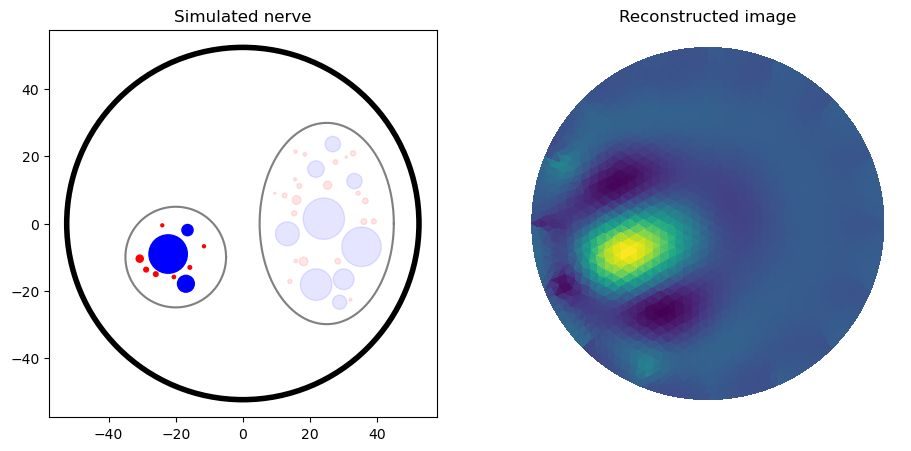

In [18]:
inv_pb_2 = eit.pyeit_inverse(data=fem_res_2)

ds = inv_pb_2.solve(i_t=i_tmax)[0]

# draw
fig, axs2 = plt.subplots(1, 2, figsize=(11, 9))
nrn_res_2.plot_recruited_fibers(axs2[0])

axs2[0].set_title("Simulated nerve")

inv_pb_2.plot(ax=axs2[1], i_t=i_tmax)
axs2[1].set_title("Reconstructed image")
axs2[1].set_aspect("equal", adjustable="box")

Final summary plot
------------------

Text(0.5, 1.0, 'Filtered reconstruction')

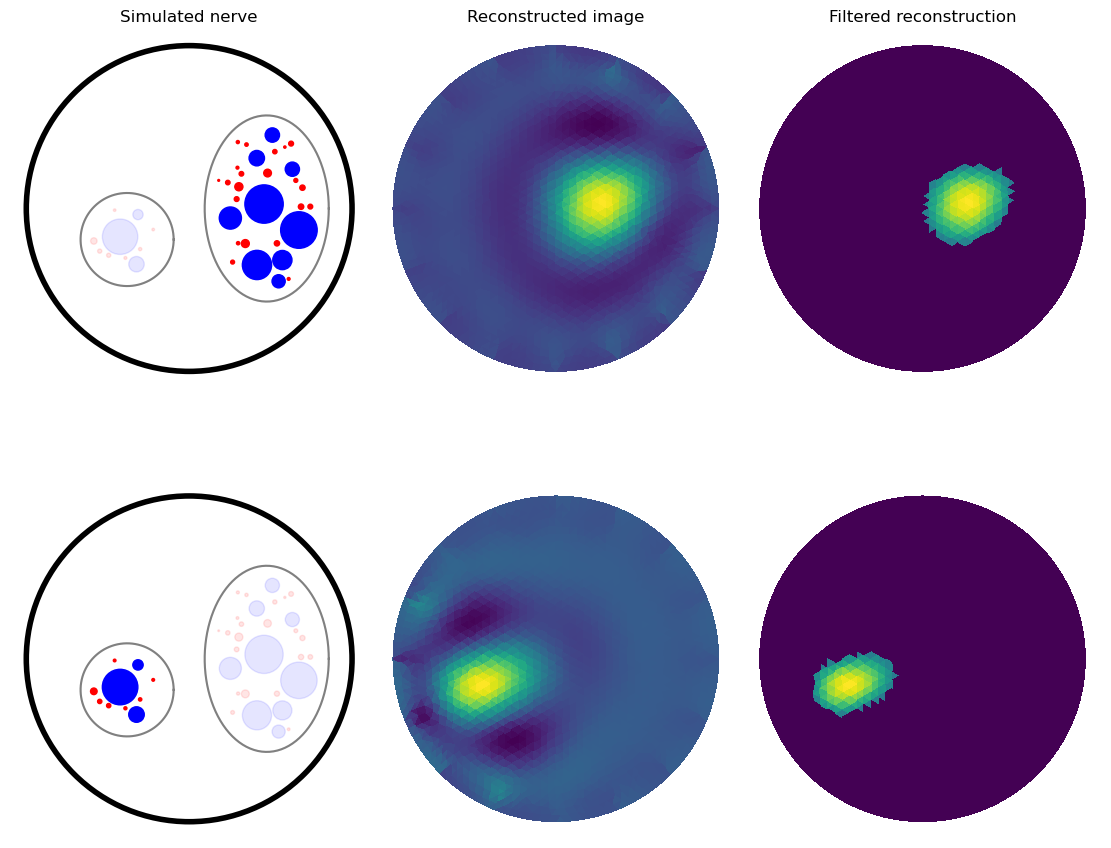

In [19]:
# draw
fig, axs = plt.subplots(2, 3, figsize=(11, 9), layout="constrained")

nrn_res.plot_recruited_fibers(axs[0,0])
axs[0,0].set_axis_off()

inv_pb.plot(ax=axs[0,1], i_t=i_tmax)
axs[0,1].set_aspect("equal", adjustable="box")
inv_pb.plot(ax=axs[0,2], i_t=i_tmax, filter=eit.utils.thr_window)
axs[0,2].set_aspect("equal", adjustable="box")
nrn_res_2.plot_recruited_fibers(axs[1,0])
axs[1,0].set_axis_off()

inv_pb_2.plot(ax=axs[1,1], i_t=i_tmax)
axs[1,1].set_aspect("equal", adjustable="box")
inv_pb_2.plot(ax=axs[1,2], i_t=i_tmax, filter=eit.utils.thr_window)
axs[1,2].set_aspect("equal", adjustable="box")

axs[0,0].set_title("Simulated nerve")
axs[0,1].set_title("Reconstructed image")
axs[0,2].set_title("Filtered reconstruction")

